In [2]:
pip install formulaic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 1.0 MB/s eta 0:00:00


In [3]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from formulaic import model_matrix


In [4]:
def generar_datos(n=1000, amin=0, amax=20, bmin=5, bmax=20, seed=2024):
    np.random.seed(seed)
    brange = bmax - bmin
    a = stats.uniform.rvs(size=n, loc=amin, scale=amax - amin)
    b = stats.norm.rvs(size=n, loc=bmin + brange / 2, scale=brange / 8)
    eps = stats.norm.rvs(size=n, loc=0, scale=4)
    y = 1 + 3 * a - 2 * b + 1.5 * a * b - 0.8 * a**2 + 0.6 * b**2 + eps
    return pd.DataFrame({"a": a, "b": b}), pd.Series(y)


X, y = generar_datos()

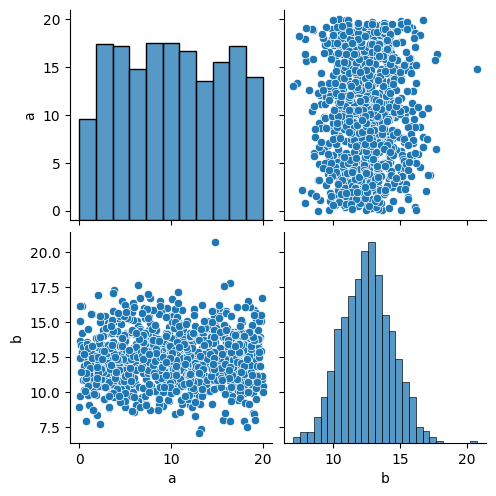

In [6]:
sns.pairplot(X)

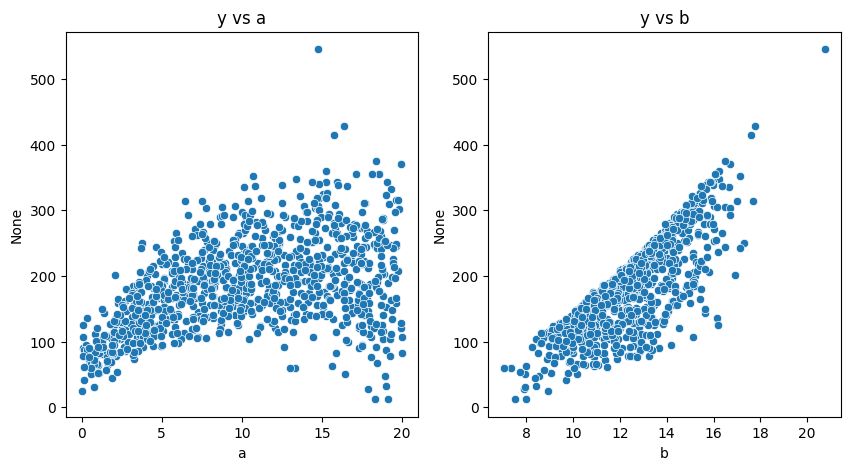

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
for i, col in enumerate(X):
    sns.scatterplot(x=X[col], y=y, ax=axs[i])
    axs[i].set_title(f"y vs {col}")

In [10]:
test_split = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [11]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)


LinearRegression()

In [12]:
lr1.intercept_
beta1 = pd.Series(lr1.coef_, index=X_train.columns)
beta1["intercept"] = lr1.intercept_
beta1

a              5.629731
b             28.580803
intercept   -229.549422
dtype: float64

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [14]:
y_pred = lr1.predict(X_test)
print(
    "# RMSE",
    f"Train: {rmse(lr1.predict(X_train), y_train):.4f}", # f?
    "Test:  %.4f" % rmse(y_pred, y_test), # % reemplaza en el string el valor indicado luego del %
    sep="\n", # Con qué voy a separar los strings
)

# RMSE
Train: 27.9140
Test:  26.9482


In [15]:
df_test = pd.concat(
    [
        X_test,
        y_test.rename("y"),
        pd.Series(y_pred, name="y_pred", index=y_test.index), # pd.concat une según índices, si son iguales los agrupa.
    ],
    axis=1,
)
df_test.head()

,a,b,y,y_pred
266,13.545818,13.067298,240.563671,220.183767
797,3.638590,9.945465,97.857949,75.184226
237,9.796413,14.673599,265.678464,244.984996
566,12.207071,13.128907,241.511594,214.407826
6,14.544803,14.892848,303.784302,277.983453


In [16]:
df_test = X_test.copy()
df_test["y"] = y_test
df_test["y_pred"] = y_pred
df_test["resid"] = df_test["y"] - df_test["y_pred"]
df_test.head()

,a,b,y,y_pred,resid
266,13.545818,13.067298,240.563671,220.183767,20.379904
797,3.638590,9.945465,97.857949,75.184226,22.673723
237,9.796413,14.673599,265.678464,244.984996,20.693468
566,12.207071,13.128907,241.511594,214.407826,27.103768
6,14.544803,14.892848,303.784302,277.983453,25.800849


### Análisis de residuos

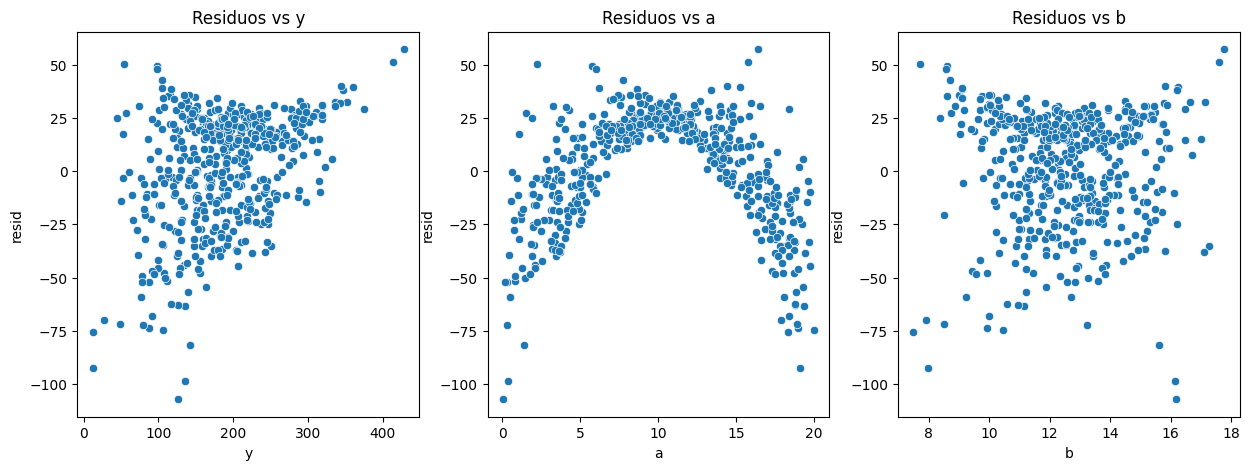

In [17]:
fig, axs= plt.subplots(1, 3, figsize = (15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()): # zip crea tuplas con los primeros elementos de todas las listas, los segundos de todas las listas, etc.
    sns.scatterplot(x=versus, y="resid", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

Pareciera haber alguna relación cuadrática entre los residuos y $a$, entonces...

In [18]:
formula = "~ poly(a, 2, raw=True) * b"
# Como solo tiene RHS, no devuelve $y$
X_train2 = model_matrix(formula, data=X_train)
X_train2.head()
# pueden explicar por qué quedan las columnas que quedas?

,Intercept,"poly(a, 2, raw=True)[0]","poly(a, 2, raw=True)[1]",b,"poly(a, 2, raw=True)[0]:b","poly(a, 2, raw=True)[1]:b"
259,1.0,13.305749,177.042958,7.325682,97.473683,1296.960365
835,1.0,18.272986,333.902004,14.242674,260.256176,4755.657359
516,1.0,6.182853,38.227666,13.465392,83.254534,514.750506
35,1.0,5.785623,33.473431,16.014351,92.652996,536.055287
29,1.0,7.633019,58.262979,12.203706,93.151121,711.024276


In [20]:
import re


def nombres_poli(s):
    repl = lambda m: f"{m.group(1)}^{int(m.group(2))+1}"
    nombres = re.sub(r"poly\((\w), \d+, raw=True\)\[(\d)\]", repl, s).replace("^1", "")
    return nombres

np.vectorize(nombres_poli)(X_train2.columns)

array(['Intercept', 'a', 'a^2', 'b', 'a:b', 'a^2:b'], dtype='<U9')

### np.vectorize

In [21]:
assert all(
    np.vectorize(nombres_poli)(X_train2.columns)
    == [nombres_poli(c) for c in X_train2.columns]
)

In [22]:
lr2 = LinearRegression(fit_intercept=False)  # Ya está incluido en model_matrix
lr2.fit(X_train2, y_train)


LinearRegression(fit_intercept=False)

In [23]:
def betas(lr, train):
    beta = pd.Series(lr.coef_, index=train.columns)
    if lr.fit_intercept:
        beta["Intercept"] = lr.intercept_
    beta.index = beta.index.map(nombres_poli)
    return beta


betas(lr2, X_train2)

Intercept   -85.394234
a             2.019908
a^2          -0.765002
b            12.549552
a:b           1.590265
a^2:b        -0.003302
dtype: float64

In [24]:
def mostrar_rmse(lr, X_train, y_train, X_test, y_test):
    print(
        "# RMSE",
        f"Train: {rmse(lr.predict(X_train), y_train):.4f}",
        "Test:  %.4f" % rmse(lr.predict(X_test), y_test),
        sep="\n",
    )


mostrar_rmse(lr2, X_train2, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 5.2536
Test:  5.0030


In [25]:
y_pred2 = lr2.predict(model_matrix(formula, data=X_test))
df_test = df_test.rename(columns={"y_pred": "y_pred1", "resid": "resid1"})
df_test["y_pred2"] = y_pred2
df_test["resid2"] = df_test["y"] - df_test["y_pred2"]

Text(0.5, 1.0, "92.60% de las observaciones 'ajustan mejor' con lr2")

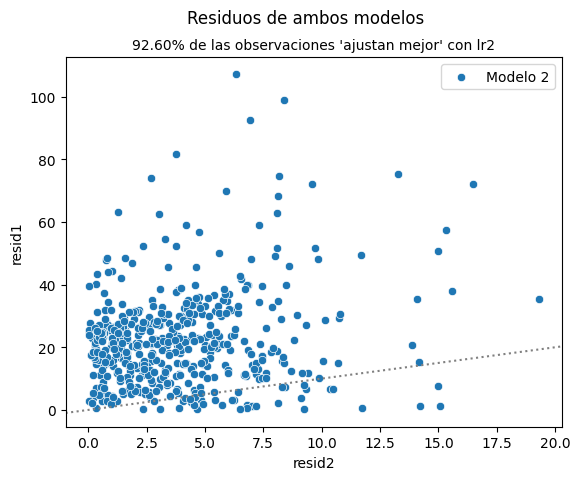

In [26]:
sns.scatterplot(x="resid2", y="resid1", data=df_test.abs(), label="Modelo 2")
plt.axline((0, 0), slope=1, color="gray", linestyle="dotted")
plt.suptitle(f"Residuos de ambos modelos")
perc_mejora = 100 * (df_test.resid2.abs() < df_test.resid1.abs()).mean()
plt.title(f"{perc_mejora:.2f}% de las observaciones 'ajustan mejor' con lr2", fontsize=10)

In [27]:
# Otra manera de calcular RMSE Test
df_test[["resid1", "resid2"]].pow(2).mean().apply(np.sqrt)

resid1    26.948153
resid2     5.003048
dtype: float64

Revisamos otra vez la estructura de los residuos

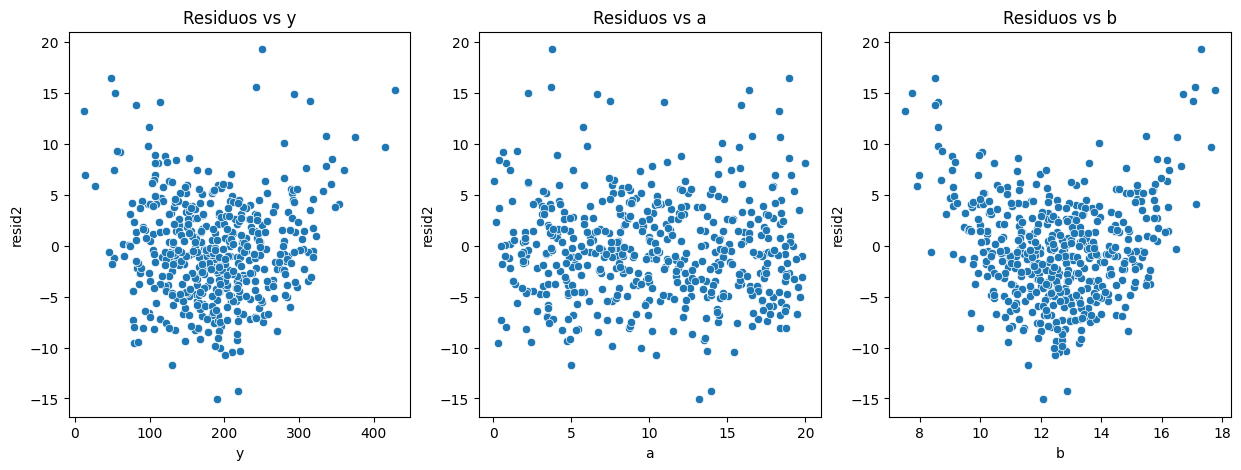

In [28]:
fig, axs= plt.subplots(1, 3, figsize = (15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()):
    sns.scatterplot(x=versus, y="resid2", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

$y \sim a$ parece bien capturado, pero aún queda una estructura contra $b$. Será cuadrática también?

In [31]:
formula = "~ 0 + poly(a, 2, raw=True) * poly(b, 2, raw=True)"
X_train3 = model_matrix(formula, data=X_train)
X_train3.shape, np.vectorize(nombres_poli)(X_train3.columns)

((500, 8),
 array(['a', 'a^2', 'b', 'b^2', 'a:b', 'a^2:b', 'a:b^2', 'a^2:b^2'],
       dtype='<U7'))

¿Por qué hay 8 terminos y no $3 \times 3=9$? ¿Se acabará algún día este proceso?

## Regrsión Grieta (AKA Ridge)

Una hipótesis: si le doy suficientes grados de libertad al modelo, y regularizo fuertemente, debería encontrar un modelo simple que ajuste a los datos sin demasiado esfuerzo. Será verdad?

In [32]:
from sklearn.linear_model import Ridge
formula = "~ 0 + poly(a, 3, raw=True) * poly(b, 3, raw=True)"
X_train4 = model_matrix(formula, data=X_train)

lr4 = Ridge(alpha=100)
lr4.fit(X_train4, y_train)

Ridge(alpha=100)

In [33]:
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 4.1456
Test:  4.1330


In [35]:
pd.DataFrame({"lr2": betas(lr2, X_train2), "lr4": betas(lr4, X_train4)}).round(4)

,lr2,lr4
Intercept,-85.3942,13.3840
a,2.0199,0.1275
a:b,1.5903,0.6183
a:b^2,NaN,0.1982
a:b^3,NaN,-0.0086
a^2,-0.7650,-0.0742
a^2:b,-0.0033,-0.0177
a^2:b^2,NaN,-0.0119
a^2:b^3,NaN,0.0007
a^3,NaN,-0.0306


Nada mal! Pero se podrá mejorar aún más? Cómo encunetro el valor óptimo de la penalización $\alpha$? CV al rescate

## Validación cruzada con scikit-learn
### np.logspace

In [37]:
np.logspace(0, 2, 5) # Se utiliza para dar posibles alphas

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

In [38]:
alfas = np.logspace(-3, 3, 61)

In [40]:
alfas[:5].round(3), alfas[-5:].round(3)

(array([0.001, 0.001, 0.002, 0.002, 0.003]),
 array([ 398.107,  501.187,  630.957,  794.328, 1000.   ]))

In [41]:
def norma(vec):
    return np.sqrt((vec ** 2).sum())

In [42]:
assert norma(np.array([3, 4])) == 5

In [43]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


rmse_train = {}
rmse_test = {}
beta_norm = {}
intercept = {}
for alfa in alfas:
    ridge = Ridge(alpha=alfa)
    ridge.fit(X_train4, y_train)
    rmse_train[alfa] = rmse(ridge.predict(X_train4), y_train)
    rmse_test[alfa] = rmse(ridge.predict(model_matrix(formula, X_test)), y_test)
    beta_norm[alfa] = norma(ridge.coef_)
    intercept[alfa] = ridge.intercept_

    logger.info(f"Alfa: {alfa.round(3):.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.23895e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.34307e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.47424e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.63949e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

Fíjense qué interesante: efecivamente para alfas muy pequeños, cuando Ridge es casi igual a la reg. lineal "vainilla", la matrix efectivamente está mal condicionada.

In [44]:
data = pd.DataFrame(
    {
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "beta_norm": beta_norm,
        "intercept": intercept,
    }
).reset_index(names="alfa")

In [45]:
data

,alfa,rmse_train,rmse_test,beta_norm,intercept
0,0.001000,4.091960,4.126075,71.069989,-203.045668
1,0.001259,4.092071,4.125559,68.153775,-197.204771
2,0.001585,4.092224,4.124990,64.838346,-190.519798
3,0.001995,4.092427,4.124377,61.142824,-183.003951
4,0.002512,4.092688,4.123733,57.114002,-174.718438
...,...,...,...,...,...
56,398.107171,4.158831,4.139336,0.346841,16.986181
57,501.187234,4.160033,4.139753,0.330228,17.220412
58,630.957344,4.161051,4.140039,0.318549,17.390337
59,794.328235,4.161931,4.140223,0.310289,17.510678


### Interludio: $\alpha \rightarrow \infty$?

In [46]:
ridge = Ridge(alpha=1e100)
ridge.fit(X_train4, y_train)
ridge.intercept_

184.0835508207187

### np.isclose

In [47]:
assert np.isclose(y_train.mean(), ridge.intercept_)

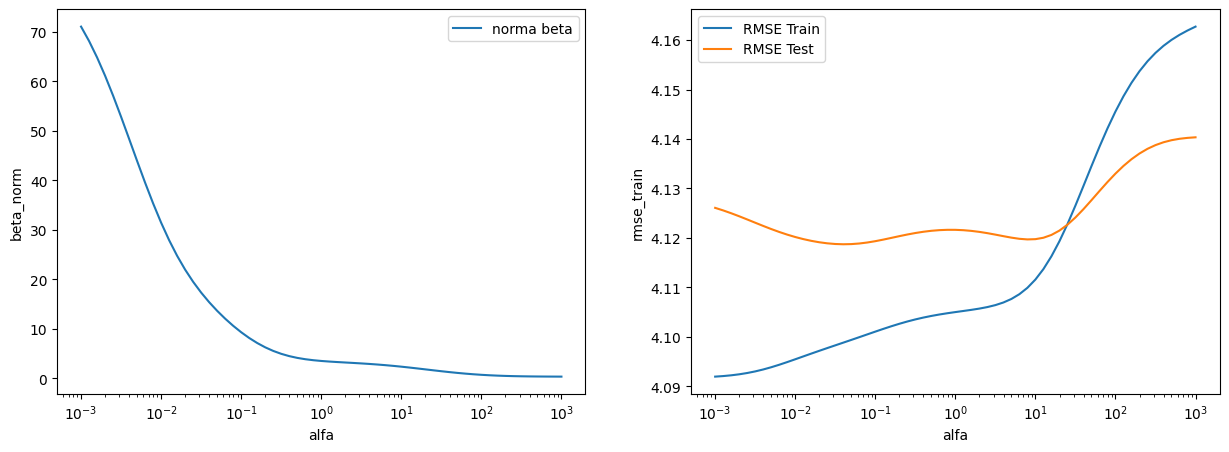

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
sns.lineplot(data=data, x="alfa", y="beta_norm", label="norma beta", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept")
sns.lineplot(data=data, x="alfa", y="rmse_train", label="RMSE Train", ax=axs[1])
sns.lineplot(data=data, x="alfa", y="rmse_test", label="RMSE Test", ax=axs[1])
plt.xscale("log")  # Probar comentando esta línea
plt.legend()

In [50]:
optimo = data.iloc[data.rmse_test.idxmin()]
optimo

alfa           0.039811
rmse_train     4.098827
rmse_test      4.118717
beta_norm     15.354337
intercept    -68.855605
Name: 16, dtype: float64

In [53]:
lr4 = Ridge(alpha=optimo.alfa)
lr4.fit(X_train4, y_train)
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 4.0988
Test:  4.1187


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.82733e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [52]:
betas(lr4, X_train4).abs().sort_values(ascending=False)

Intercept    68.855605
b            14.908632
a             2.610703
a:b           2.391960
b^2           0.734779
a^2           0.474662
a^2:b         0.405558
a:b^2         0.123736
a^3           0.056187
a^2:b^2       0.038155
b^3           0.034549
a^3:b         0.016472
a:b^3         0.004284
a^3:b^2       0.001471
a^2:b^3       0.001097
a^3:b^3       0.000041
dtype: float64

Para reflexionar: ¿Qué es más importante, $$0.000012\ a^3:b^3$$ o $$0.485267\ a:b$$? ¿De qué depende?

### Una vez más, con ~~sentimiento~~ `GridSearchCV`

In [55]:
from sklearn.model_selection import GridSearchCV

# param_grid = {"alpha": alfas}
mas_alfas = np.unique(np.concatenate([alfas, np.logspace(-4, 4, 41)]))
param_grid = {"alpha": mas_alfas}
gs = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)
gs.fit(X_train4, y_train)

gs.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.9162e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.88781e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.93917e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.79958e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning

{'alpha': 10000.0}

In [56]:
cv_results_ = pd.DataFrame(gs.cv_results_)[
    ["param_alpha", "mean_test_score", "mean_train_score"]
]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1

In [57]:
cv_results_.dtypes

param_alpha          object
mean_test_score     float64
mean_train_score    float64
dtype: object

In [58]:
cv_results_["param_alpha"] = cv_results_["param_alpha"].astype(float)

In [59]:
cv_results_.set_index("param_alpha").loc[[optimo.alfa, gs.best_params_["alpha"]]]

,mean_test_score,mean_train_score
param_alpha,,
0.039811,4.348408,4.080873
10000.000000,4.322827,4.180770


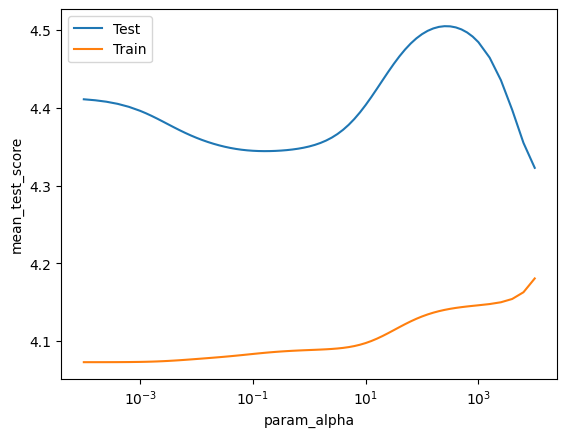

In [60]:
sns.lineplot(x="param_alpha", y="mean_test_score", data=cv_results_, label="Test")
sns.lineplot(x="param_alpha", y="mean_train_score", data=cv_results_, label="Train")
plt.xscale("log")
plt.show()

In [62]:
mejor = gs.best_estimator_
mostrar_rmse(mejor, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 4.1855
Test:  4.1567


In [63]:
formula_real = "~ poly(a, 2, raw=True) + poly(b, 2, raw=True) + a:b"
X_real = model_matrix(formula_real, data=X_train)
lr_real = LinearRegression()
lr_real.fit(X_real, y_train)
mostrar_rmse(lr_real, X_real, y_train, model_matrix(formula_real, X_test), y_test)


# RMSE
Train: 4.1334
Test:  4.1103


In [64]:
betas(lr_real, X_real).round(3)

Intercept    5.947
a            2.971
a^2         -0.804
b           -2.658
b^2          0.621
a:b          1.508
dtype: float64

Los coeficientes originales eran:
$$ z = 1 + 3x - 2y + 1.5 xy - 0.8 x^2 + 0.6 y^2 + \epsilon$$

Entonces, ¿es cierta la hipótesis? ¿Da lo mismo un modelo "genérico" con regularización que un modelo "ad-hoc"? ¿En qué tipo de tareas?

## Consigna

Cargue el dataset `wine` de scikit-learn, e intente predecir el contenido de alcohol (`alcohol`) de cada vino, usando las características a su disposición, usando una regresión Ridge sobre una matriz de diseño sesudamente construida.

NOTA: El dataset está preparado para utilizarlo en problemas de clasificación, así que tendrá que trocar el objetivo ("target") con la variable predictora "alcohol". Note que la etiqueta del vino peude ser de utilidad en el diseño del modelo.

In [ ]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [ ]:
dir(wine)  # estos son los atributos del objeto, exprorelos!

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']